### Exercise: Differential Gene Expression Analysis
In this exercise, we will calculate and analyse differentially expressed genes between two different conditions of in vitro stimulated PBMCs.

#### Import required packages and data
Following sc-best-practices (https://www.sc-best-practices.org/conditions/differential_gene_expression.html), we will use the Kang dataset, which is a 10x droplet-based scRNA-seq peripheral blood mononuclear cell (PBMC) data from 8 Lupus patients before and after 6h-treatment with INF-β (16 samples in total) (Kang et al., 2018).

You need to download the dataset from the course github repository (https://github.com/buchauer-lab/charite-sc-data-course/tree/main/materials/Day4), unzip it, and use the correct path to the data on your system in the import function below.

In [1]:
# general data handling
import numpy as np
import pandas as pd
from scipy import sparse

# single cell analysis
import scanpy as sc
import decoupler as dc

# differential expression testing
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# adjust the path to the location of the folder "Kang2018" on your system
kang_data_path = '/Users/libuchauer/Projects/Kang2018/'

In [3]:
# import single cell data
adata = sc.read_10x_mtx(kang_data_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    var: 'gene_ids', 'feature_types'

In [5]:
# import meta data
metadata_df = pd.read_csv(kang_data_path + 'metadata.csv', index_col=0)

In [6]:
# inspect the metadata
metadata_df.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


In [7]:
# add metadata to adata.obs
adata.obs = adata.obs.join(metadata_df)

In [8]:
# inspect adata.obs to ensure everything worked
adata.obs.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,label,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,ctrl,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,ctrl,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,ctrl,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,ctrl,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,ctrl,4,Dendritic cells,patient_1039,1857.0,928,12,12


In [9]:
# print the different cell type labels which appear here to screen
adata.obs['cell_type'].unique()

array(['CD14+ Monocytes', 'CD4 T cells', 'Dendritic cells', 'NK cells',
       'CD8 T cells', 'B cells', 'FCGR3A+ Monocytes', 'Megakaryocytes'],
      dtype=object)

In [10]:
# print the patient identifiers
adata.obs['replicate'].unique()

array(['patient_1016', 'patient_1256', 'patient_1488', 'patient_1039',
       'patient_1015', 'patient_107', 'patient_1244', 'patient_101'],
      dtype=object)

In [11]:
# print the different conditions, here called 'labels'
adata.obs['label'].unique()

array(['ctrl', 'stim'], dtype=object)

#### Data preparation
We will perform a very basic quality control and calculate pseudobulks for each patient which we will need for differential expression analysis with pyDESeq2.


In [12]:
# use scanpy's filter_cells and filter_genes functions to remove cells with 
# less than 200 genes and genes which appear in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [13]:
adata

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [14]:
# next, we need to introduce a column that holds the sample information, in our case a combination of "replicate" and "label"
adata.obs['sample'] = adata.obs['replicate'] + '_' + adata.obs['label']

In order to create pseudobulks (gene expression vectors per sample, generated by summing up all single cell expression vectos of a given cell type in that sample), we will use functionality from `decopupler`.

In [15]:
# use the decoupler function dc.pp.pseudobulk to generate an anndata object of pseudobulks
# use mode='sum' to create pseudobulks by summing
pb_data = dc.pp.pseudobulk(adata, sample_col='sample', groups_col='cell_type', mode='sum')

In [16]:
# inspect the object - how many observations are in there now? Is this according to your expectation?
pb_data

AnnData object with n_obs × n_vars = 128 × 15701
    obs: 'sample', 'cell_type', 'label', 'replicate', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'psbulk_props'

In [17]:
# inspect the metadata in the obs dataframe
pb_data.obs

,sample,cell_type,label,replicate,psbulk_cells,psbulk_counts
patient_1015_ctrl_B cells,patient_1015_ctrl,B cells,ctrl,patient_1015,459.0,556570.0
patient_1015_stim_B cells,patient_1015_stim,B cells,stim,patient_1015,366.0,481886.0
patient_1016_ctrl_B cells,patient_1016_ctrl,B cells,ctrl,patient_1016,125.0,152335.0
patient_1016_stim_B cells,patient_1016_stim,B cells,stim,patient_1016,123.0,150619.0
patient_101_ctrl_B cells,patient_101_ctrl,B cells,ctrl,patient_101,106.0,124446.0
...,...,...,...,...,...,...
patient_1244_stim_NK cells,patient_1244_stim,NK cells,stim,patient_1244,107.0,110057.0
patient_1256_ctrl_NK cells,patient_1256_ctrl,NK cells,ctrl,patient_1256,242.0,213089.0
patient_1256_stim_NK cells,patient_1256_stim,NK cells,stim,patient_1256,186.0,177173.0
patient_1488_ctrl_NK cells,patient_1488_ctrl,NK cells,ctrl,patient_1488,119.0,102821.0


In [18]:
# now, we want to remove pseudobulks which do not have at least 30 cells or 3000 counts
# use the function dc.pp.filter_samples to accomplish this
dc.pp.filter_samples(pb_data, min_cells=30, min_counts=1000)

#### Basic analysis of the pseudobulked data objects
In differential expression testing, defining the right statistical model is very important. In order to identify the covariates which drive differences in our dataset (these are the covariates we should include in our model), we use scanpy to calculate a PCA for the pseudobulked data and inspect a series of PCA plots coloured by covariates.

In [20]:
# we make a copy of the data object above as we will lognormalize it for calculating the PCA
pb_copy = pb_data.copy()

In [21]:
# the .obs metadata contains a column psbulk_counts with count sums, add a column which contains the np.log of this
pb_copy.obs['log_psbulk_counts'] = np.log(pb_copy.obs['psbulk_counts'])

In [22]:
# as you would for single cell data, perform the following steps using scanpy functions:
# 1. normalize total counts to a target sum 1e6
# 2. log1p transform the data
# 3. calculate a PCA
sc.pp.normalize_total(pb_copy, target_sum=1e6)
sc.pp.log1p(pb_copy)
sc.pp.pca(pb_copy)

... storing 'feature_types' as categorical


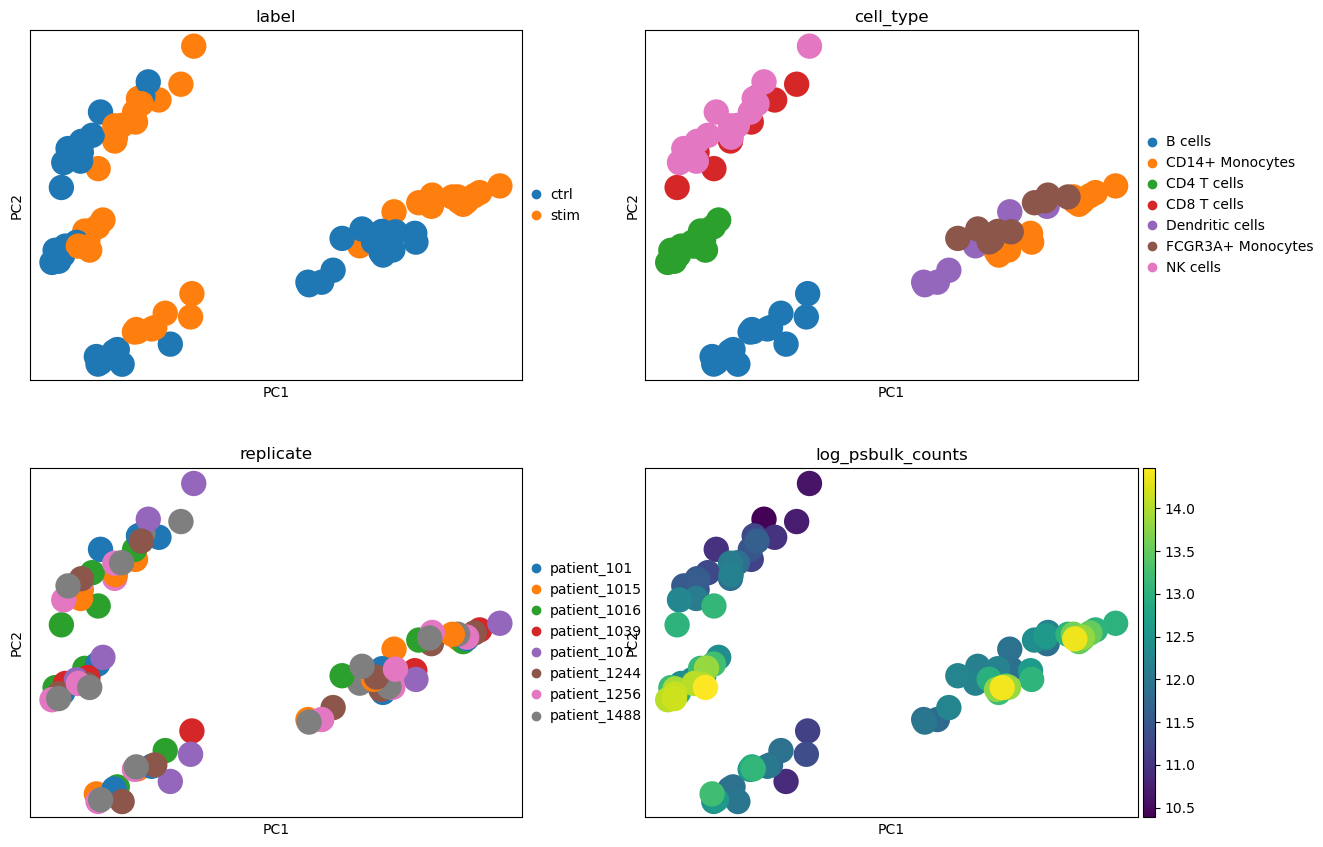

In [23]:
# plot PCA plots coloured by label, cell_type, replicate, log_lib_size
sc.pl.pca(pb_copy, color=['label', 'cell_type', 'replicate', 'log_psbulk_counts'], ncols=2)

Which of the above covariates seem to be strongly driving variance in PC1  or PC2? Discuss.

#### Differential expression analysis with PyDESeq2
We will now use the pseudobulked data of monocytes only for differential expression testing. We first need to get the data into the right format - PyDESeq2 expects a pandas dataframe of the gene expression data as well as of the metadata.

In [24]:
# First, subset the pseudobulked anndata object to only the monoyte populations.
mono_pb = pb_data[pb_data.obs['cell_type']=='CD14+ Monocytes']

In [25]:
# Next, we want to remove genes for which we do not expect relevant results
# Discuss with your neighbor why we want to reduce the number of genes for which we 
# perform differential expression testing.
# we want to remove all genes for which we do not see at least 15 counts in total
# use dc.pp.filter_by_expr to accomplish this
dc.pp.filter_by_expr(
    adata=mono_pb,
    min_total_count=15,
)

# we want to retain only genes which are present in at least 10% of cells in at least 3 samples
# use dc.pp.filter_prop to accomplish this
dc.pp.filter_by_prop(
    adata=mono_pb,
    min_prop=0.1,
    min_smpls=3,
)

How many genes did we lose through this filtering?

In [26]:
# Let's make a dataframe of the counts
counts_df = pd.DataFrame(data=mono_pb.X, index=mono_pb.obs.index, columns=mono_pb.var.index)

In [27]:
# Insepct, always inspect...
counts_df.head()

,HP1BP3,GSTO1,PPDPF,TGFBI,TMED9,PSMC2,ARPC3,OAZ2,SUMO2,SRSF11,...,TNFSF13B,PPT1,PFKFB3,HLA-DRB1,SLC39A1,ASAH1,LDHB,PDIA3,TUFM,COX4I1
patient_1015_ctrl_CD14+ Monocytes,123.0,2091.0,646.0,329.0,308.0,150.0,2051.0,241.0,521.0,153.0,...,127.0,98.0,57.0,4768.0,77.0,415.0,84.0,605.0,245.0,1787.0
patient_1015_stim_CD14+ Monocytes,61.0,2396.0,620.0,121.0,160.0,118.0,1497.0,71.0,346.0,113.0,...,2626.0,52.0,115.0,5111.0,50.0,317.0,47.0,546.0,72.0,910.0
patient_1016_ctrl_CD14+ Monocytes,67.0,999.0,213.0,211.0,112.0,63.0,909.0,85.0,235.0,59.0,...,115.0,50.0,30.0,1829.0,26.0,227.0,72.0,245.0,89.0,1058.0
patient_1016_stim_CD14+ Monocytes,29.0,1018.0,167.0,111.0,49.0,45.0,685.0,35.0,173.0,45.0,...,1330.0,37.0,36.0,1887.0,20.0,145.0,40.0,202.0,31.0,519.0
patient_101_ctrl_CD14+ Monocytes,37.0,815.0,136.0,161.0,115.0,48.0,688.0,85.0,152.0,40.0,...,3.0,45.0,12.0,736.0,26.0,210.0,22.0,238.0,48.0,519.0


In [28]:
# We also need the metadata in a corresponding format with sample as index
metadata_df = mono_pb.obs

In [29]:
# Inspect!
metadata_df.head()

,sample,cell_type,label,replicate,psbulk_cells,psbulk_counts
patient_1015_ctrl_CD14+ Monocytes,patient_1015_ctrl,CD14+ Monocytes,ctrl,patient_1015,859.0,1793578.0
patient_1015_stim_CD14+ Monocytes,patient_1015_stim,CD14+ Monocytes,stim,patient_1015,718.0,1759808.0
patient_1016_ctrl_CD14+ Monocytes,patient_1016_ctrl,CD14+ Monocytes,ctrl,patient_1016,393.0,742765.0
patient_1016_stim_CD14+ Monocytes,patient_1016_stim,CD14+ Monocytes,stim,patient_1016,355.0,732718.0
patient_101_ctrl_CD14+ Monocytes,patient_101_ctrl,CD14+ Monocytes,ctrl,patient_101,207.0,531210.0


In [30]:
mono_pb

AnnData object with n_obs × n_vars = 16 × 1966
    obs: 'sample', 'cell_type', 'label', 'replicate', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'psbulk_props'

#### Now for the actual differential expression testing!
The steps below follow the PyDESeq2 tutorial at https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html#sphx-glr-auto-examples-plot-minimal-pydeseq2-pipeline-py which you can visit for further info.
The important part below is the definition of the design matrix, i.e. which covariate we expect the gene expression to depend on. In our case, this is the metadata entry "label" which represents the conditions control vs. stimulated.

In [31]:
# First step - initialize a DeSeqDataSet, the object which holds our data and later on also the results
inference = DefaultInference(n_cpus=None)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_df,
    design="~label",
    refit_cooks=True,
    inference=inference,
)

In [32]:
# Second step - fitting dispersions, size factors etc for each gene
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.13 seconds.

Fitting dispersion trend curve...
/opt/homebrew/Caskroom/miniforge/base/envs/scrnaseq/lib/python3.10/site-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.15 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



In [33]:
# Never hurts to inspect the object (actually, dds objects use AnnData as a backbone!)
dds

AnnData object with n_obs × n_vars = 16 × 1966
    obs: 'sample', 'cell_type', 'label', 'replicate', 'psbulk_cells', 'psbulk_counts', 'size_factors', 'replaceable'
    var: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'mean_disp', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [34]:
# We can use anndata-like calls to inspect fitted dispersions and log fold changes:
print(dds.var["dispersions"])
print(dds.varm["LFC"])

HP1BP3    0.033615
GSTO1     0.017681
PPDPF     0.034626
TGFBI     0.085770
TMED9     0.033395
            ...   
ASAH1     0.071468
LDHB      0.081602
PDIA3     0.030650
TUFM      0.033400
COX4I1    0.014576
Name: dispersions, Length: 1966, dtype: float64
        Intercept  label[T.stim]
HP1BP3   3.836951      -0.578253
GSTO1    6.718117       0.405246
PPDPF    5.153116       0.232332
TGFBI    5.148733      -0.706065
TMED9    4.745684      -0.462913
...           ...            ...
ASAH1    5.082731       0.282858
LDHB     3.708821      -0.157141
PDIA3    5.552801       0.167003
TUFM     4.121777      -0.836596
COX4I1   6.503357      -0.392565

[1966 rows x 2 columns]


In [35]:
# Third step - no we use the fitted dispersions and LFCs to do actual statistical tests.
# For this, a new class is introduced: DeSeqStats objects.
ds = DeseqStats(dds, contrast=["label", "ctrl", "stim"], inference=inference)

In [36]:
# using this object, a Wald test can be run and results displayed like this:
ds.summary()

Running Wald tests...
... done in 0.08 seconds.



Log2 fold change & Wald test p-value: label ctrl vs stim
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
HP1BP3    36.611101        0.834243  0.182875  4.561829  5.070987e-06   
GSTO1   1036.364952       -0.584647  0.098811 -5.916809  3.282474e-09   
PPDPF    193.887008       -0.335184  0.144510 -2.319456  2.037034e-02   
TGFBI    129.337401        1.018636  0.222843  4.571096  4.851806e-06   
TMED9     93.781581        0.667843  0.153570  4.348783  1.368950e-05   
...             ...             ...       ...       ...           ...   
ASAH1    187.956622       -0.408078  0.200572 -2.034569  4.189429e-02   
LDHB      37.439326        0.226706  0.238786  0.949408  3.424130e-01   
PDIA3    282.421252       -0.240935  0.133949 -1.798711  7.206434e-02   
TUFM      43.063570        1.206952  0.178348  6.767399  1.311179e-11   
COX4I1   558.525610        0.566351  0.092929  6.094433  1.098261e-09   

                padj  
HP1BP3  1.227778e-05  
GSTO1   1.124276e-08

### Exploring and plotting results
Results of the tests are available in tabular form in `ds.results_df`. 

In [37]:
# for ease of access, we will first reassign the result dataframe
results_df = ds.results_df

In [38]:
# inspect
results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HP1BP3,36.611101,0.834243,0.182875,4.561829,5.070987e-06,1.227778e-05
GSTO1,1036.364952,-0.584647,0.098811,-5.916809,3.282474e-09,1.124276e-08
PPDPF,193.887008,-0.335184,0.144510,-2.319456,2.037034e-02,2.944712e-02
TGFBI,129.337401,1.018636,0.222843,4.571096,4.851806e-06,1.179067e-05
TMED9,93.781581,0.667843,0.153570,4.348783,1.368950e-05,3.151470e-05


#### 1. Compare top genes by different criteria

In [39]:
# sort the dataframe by adj p val and inspect the top 10 genes
results_df.sort_values('padj').head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
IFITM2,492.727177,-4.671062,0.147902,-31.582234,6.475329e-219,1.273050e-215
IL1RN,901.540632,-6.465510,0.215576,-29.991735,1.257795e-197,1.236413e-194
SSB,366.455638,-3.338010,0.114119,-29.250130,4.473253e-188,2.931472e-185
DYNLT1,949.541445,-2.612186,0.100374,-26.024571,2.610956e-149,1.283285e-146
RTCB,152.812562,-3.433235,0.132294,-25.951560,1.746063e-148,6.865520e-146
DDX58,201.490159,-4.949796,0.194094,-25.501996,1.873295e-143,6.138163e-141
NAPA,174.397930,-2.265762,0.095903,-23.625513,2.107766e-123,5.919811e-121
TMEM50A,377.671256,-1.653756,0.077396,-21.367335,2.690594e-101,6.612134e-99
OASL,476.872558,-4.307640,0.202752,-21.245866,3.600021e-100,7.864046e-98
PLSCR1,785.849240,-2.893615,0.136402,-21.213891,7.108254e-100,1.397483e-97


In [40]:
# sort the dataframe by highest fold change and inspect the top 10 genes
results_df.sort_values('log2FoldChange', ascending=False).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
IL1B,340.877884,3.794368,0.466707,8.130081,4.290036e-16,2.495329e-15
PHLDA1,123.085159,2.665452,0.277408,9.608419,7.367152e-22,5.911763e-21
RGCC,126.093971,2.647830,0.172643,15.337057,4.323576e-53,1.491254e-51
IL8,1795.881085,2.626359,0.251836,10.428855,1.830819e-25,1.827102e-24
PID1,87.811897,2.621668,0.236063,11.105803,1.175559e-28,1.426635e-27
CTB-61M7.2,54.054122,2.590023,0.288974,8.962826,3.164606e-19,2.206247e-18
CD14,558.186313,2.521284,0.188146,13.400660,5.992807e-41,1.132871e-39
EIF3L,59.556866,2.415964,0.207788,11.627062,3.002543e-31,4.157042e-30
GLIPR1,105.438447,2.368434,0.163949,14.446144,2.651201e-47,6.858237e-46
IER3,207.150442,2.325803,0.239121,9.726483,2.324931e-22,1.928614e-21


In [41]:
# sort the dataframe by lowest fold change and inspect the top 10 genes
results_df.sort_values('log2FoldChange', ascending=True).head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ISG15,19278.176250,-7.078443,0.466621,-15.169574,5.624091e-52,1.812617e-50
IL1RN,901.540632,-6.465510,0.215576,-29.991735,1.257795e-197,1.236413e-194
IDO1,1563.308309,-5.952475,0.424799,-14.012456,1.308014e-44,2.889388e-43
APOBEC3A,3853.883401,-5.658929,0.412804,-13.708524,9.027576e-43,1.868233e-41
MX1,774.667293,-5.613637,0.441098,-12.726500,4.213033e-37,7.329931e-36
ISG20,3130.620068,-5.410548,0.273825,-19.759160,6.690919e-87,7.737851e-85
TNFSF13B,626.707813,-5.327740,0.430156,-12.385607,3.127103e-35,5.039250e-34
IFITM3,2479.392649,-5.312282,0.508213,-10.452870,1.421577e-25,1.448093e-24
LY6E,1435.983608,-5.192720,0.512127,-10.139526,3.688865e-24,3.470004e-23
DDX58,201.490159,-4.949796,0.194094,-25.501996,1.873295e-143,6.138163e-141


Why do these lists differ? Do some genes appear in several lists?

#### 2. Smear plot and volcano plot

Text(0.5, 1.0, 'Smear Plot (MA Plot)')

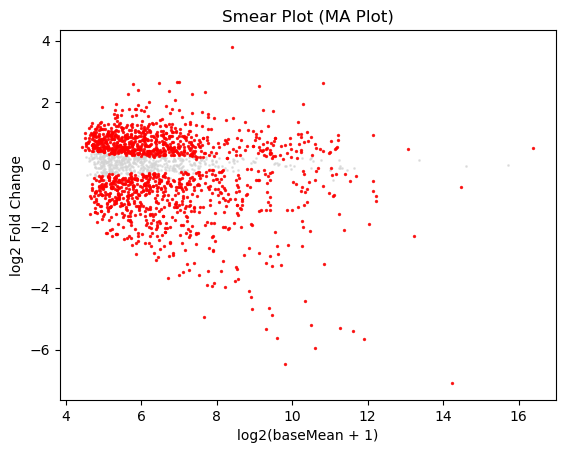

In [42]:
# Create smear plot - a 2D scatter plot with log2FoldChange on the y axis and expression on the x Axis
# use plt.scatter to achieve this
# plot np.log2(results_df['baseMean'] + 1) on the x axis
# highlight significant genes, i.e. genes with pdj < 0.5 in red
# (a simple way to achieve this is to just plot the relevant genes again in red)
avg_expression = results_df['baseMean']  # Average expression
log_fold_change = results_df['log2FoldChange']
padj = results_df['padj']

plt.scatter(np.log2(avg_expression + 1), log_fold_change, 
           c='lightgray', alpha=0.6, s=1)

sig_mask = padj < 0.05
plt.scatter(np.log2(avg_expression[sig_mask] + 1), 
           log_fold_change[sig_mask], c='red', alpha=0.8, s=2)

plt.xlabel('log2(baseMean + 1)')
plt.ylabel('log2 Fold Change')
plt.title('Smear Plot (MA Plot)')


Describe the plot, what is the general behavior we observe for significant results?

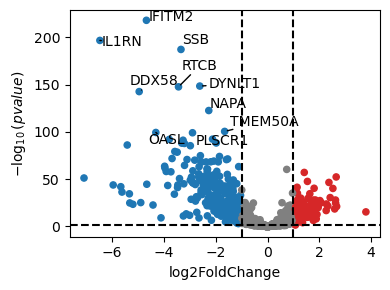

In [43]:
# use the function dc.pl.volcano to plot a volcano plot
# show the names of the top 10 differentially expressed features
# set the significance threshold to 1 log2FoldChange
# save the figure to file
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue", top=10, thr_stat=1, save='Kang_monocyte_volcano.png')

#### 3. Heatmap of top diferentially expressed genes

In [44]:
# Find the 10 top genes by FC in the stim group and the 10 top genes by FC in the control group
# and combine them into a list
l1 = results_df.sort_values('log2FoldChange', ascending=True).head(10).index.tolist()
l2 = results_df.sort_values('log2FoldChange', ascending=False).head(10).index.tolist()
top_genes = l1+l2

In [45]:
# We want to plot normalized counts which are stored in the dds object.
# For better visibility, we add a log version of these counts
dds.layers["log_normed_counts"] = np.log(dds.layers["normed_counts"]+1)

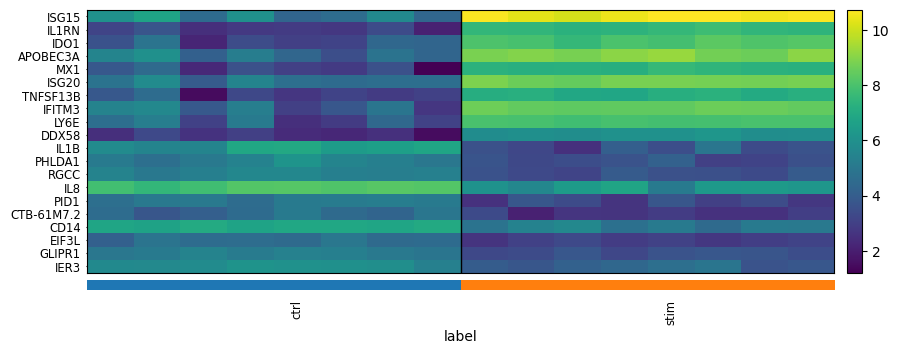

In [46]:
# Plot a heatmap of normalized counts for the top_genes list as a heatmap
# Use sc.pl.heatmap on the dds object to accomplish this. use the layer log_normed_counts
sc.pl.heatmap(dds, top_genes, groupby='label', swap_axes=True, layer="log_normed_counts")

In [47]:
dds.var_names

Index(['HP1BP3', 'GSTO1', 'PPDPF', 'TGFBI', 'TMED9', 'PSMC2', 'ARPC3', 'OAZ2',
       'SUMO2', 'SRSF11',
       ...
       'TNFSF13B', 'PPT1', 'PFKFB3', 'HLA-DRB1', 'SLC39A1', 'ASAH1', 'LDHB',
       'PDIA3', 'TUFM', 'COX4I1'],
      dtype='object', length=1966)

#### 4. Individual gene expression plots

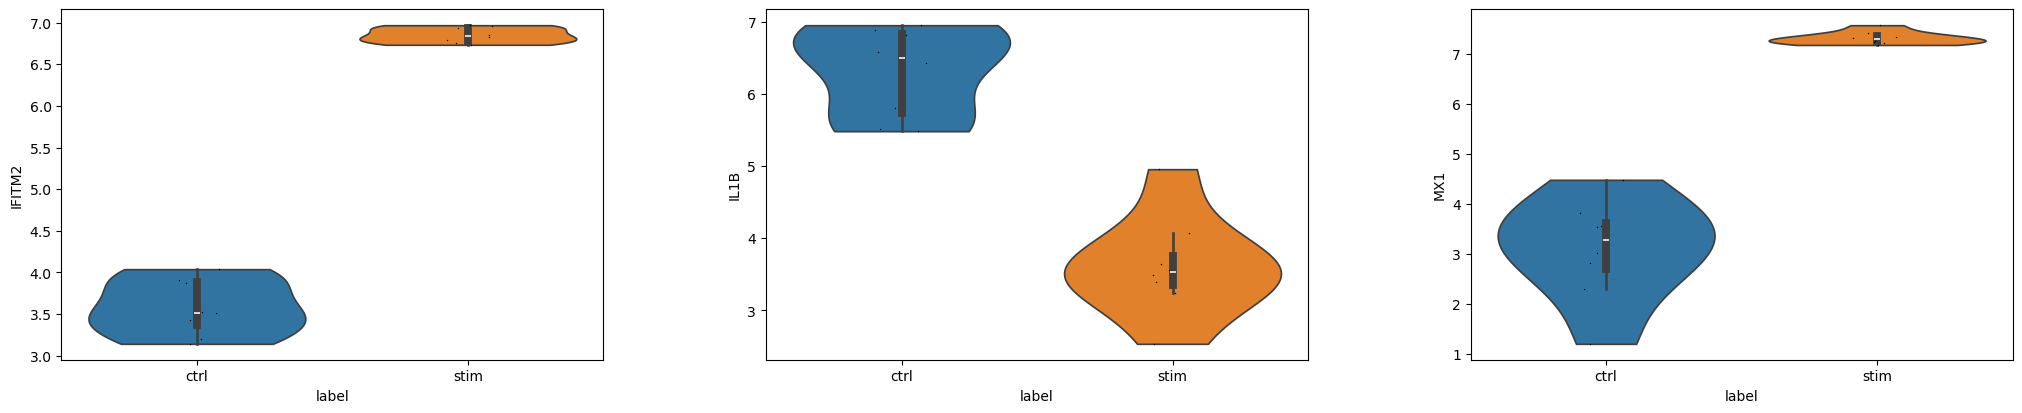

In [48]:
# pick 2 or 3 genes and plot their expression by condition in box plots, use sc.pl.violin for this
sc.pl.violin(dds, ['IFITM2', 'IL1B', 'MX1'], groupby='label', inner='box',
             layer='log_normed_counts', use_raw=False)

#### 5. Gene annotation lookup
Look up some of your top genes to find out what pathways they are involved in and what their function is. Here are some ideas to get started:
- NCBI Gene: https://www.ncbi.nlm.nih.gov/gene/
- UniProt: https://www.uniprot.org/
- GeneCards: https://www.genecards.org/  
Also, use an AI Chatbot and compare the output to what you found in above databases.

#### 6. Simple pathway / GO term investigation
You can try to paste your lists into one of the following tools (or another one of your choosing):
- Enrichr: https://maayanlab.cloud/Enrichr/
- GOrilla https://cbl-gorilla.cs.technion.ac.il/

In [49]:
# find the top 50 genes by padj and feed them into online gene ontology resources
top50 = results_df.nsmallest(50, 'padj').index.tolist()
top50

['IFITM2',
 'IL1RN',
 'SSB',
 'DYNLT1',
 'RTCB',
 'DDX58',
 'NAPA',
 'TMEM50A',
 'OASL',
 'PLSCR1',
 'TMSB10',
 'SAMD9L',
 'HSPA1A',
 'PSMA4',
 'IRF7',
 'IFI16',
 'ISG20',
 'HSPB1',
 'SPATS2L',
 'SP110',
 'SNX10',
 'MYL12A',
 'GCH1',
 'DRAP1',
 'PARP9',
 'ATG3',
 'NMI',
 'TRADD',
 'BAG1',
 'PSMA2.1',
 'BLVRA',
 'TMEM123',
 'C19orf66',
 'GBP1',
 'VAMP5',
 'SNX3',
 'BST2',
 'SAMD9',
 'NAGK',
 'MB21D1',
 'ATP6V0B',
 'TREX1',
 'RAB8A',
 'GBP4',
 'IFI35',
 'PHF11',
 'ENO1',
 'FBXO6',
 'TFEC',
 'CD164']